In [7]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
import warnings
warnings.filterwarnings('ignore')

In [8]:
# https://keras.io/datasets/#mnist-database-of-handwritten-digits
from keras.datasets import mnist

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

In [9]:
import numpy as np
import keras

# https://youtu.be/py5byOOHZM8
# https://keras.io/getting-started/sequential-model-guide/
y_train = keras.utils.to_categorical(y_train_raw, num_classes=10, dtype="uint8")
y_test = keras.utils.to_categorical(y_test_raw, num_classes=10, dtype="uint8")
x_train = x_train_raw.reshape(60000,28,28,1)
x_test = x_test_raw.reshape(10000,28,28,1)

# preprocessing: convert from grayscale to black and white
# 98.5 without, 0.9803 with
def to_black_and_white(arr, threshold):
    for val in np.nditer(arr, op_flags=['readwrite']):
        if val > threshold:
            val[...] = 255
        else:
            val[...] = 0

to_black_and_white(x_train, 15)
to_black_and_white(x_test, 15)


'Label: 5'

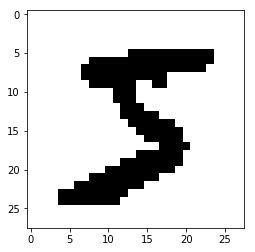

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow([255 - i for i in x_train_raw[0]], cmap='gray')
"Label: {}".format(y_train_raw[0])

In [11]:
from keras import Sequential
from keras import layers

# Dense (500, linear)
# Dense (100, linear)
# Dense (10, softmax)
# [0.6122526635818183, 0.8727999925613403]

# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
# https://keras.io/layers/convolutional/
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# training
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 31s 517us/step - loss: 0.4240 - accuracy: 0.9356
Epoch 2/10
60000/60000 [==============================] - 32s 525us/step - loss: 0.1111 - accuracy: 0.9686
Epoch 3/10
60000/60000 [==============================] - 30s 507us/step - loss: 0.1034 - accuracy: 0.9710
Epoch 4/10
60000/60000 [==============================] - 32s 527us/step - loss: 0.0988 - accuracy: 0.9721
Epoch 5/10
60000/60000 [==============================] - 33s 558us/step - loss: 0.0982 - accuracy: 0.9724
Epoch 6/10
60000/60000 [==============================] - 31s 518us/step - loss: 0.0964 - accuracy: 0.9724
Epoch 7/10
60000/60000 [==============================] - 32s 531us/step - loss: 0.0954 - accuracy: 0.9725
Epoch 8/10
60000/60000 [==============================] - 30s 502us/step - loss: 0.0955 - accuracy: 0.9721
Epoch 9/10
60000/60000 [==============================] - 32s 525us/step - loss: 0.0946 - accuracy: 0.9726
Epoch 10/10
60000/60000 [============

In [13]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# save model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
# evaluation
scores = model.evaluate(x_test, y_test)
scores

10000/10000 [==============================] - 1s 112us/step


[0.11558663325347006, 0.9660999774932861]

<Container object of 10 artists>

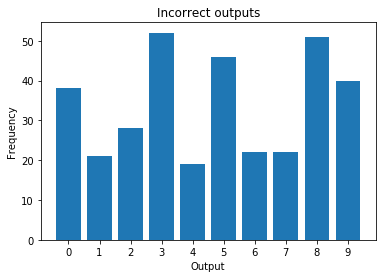

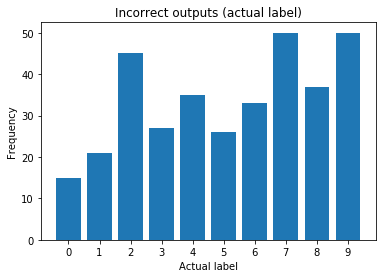

In [15]:
prediction_classes = model.predict_classes(x_test)
# ["Output: {} - Label: {}".format(predictions[i], y_test[i]) for i in range(len(predictions)) if predictions[i] != y_test[i]]

# https://stackoverflow.com/questions/4535374/initialize-a-numpy-array
nums = np.arange(0, 10)
wrong_out_dist = np.zeros((10,))
wrong_out_label_dist = np.zeros((10,))

for i in range(len(prediction_classes)):
    if prediction_classes[i] != y_test_raw[i]:
        wrong_out_dist[prediction_classes[i]] += 1
        wrong_out_label_dist[y_test_raw[i]] += 1

# https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
# https://www.programcreek.com/python/example/56587/matplotlib.pyplot.title
plt.title("Incorrect outputs")
plt.xlabel("Output")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_dist, tick_label=nums)

plt.figure()
plt.title("Incorrect outputs (actual label)")
plt.xlabel("Actual label")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_label_dist, tick_label=nums)

In [16]:
predictions = model.predict(x_test)
# same as below because of softmax?
# probs = model.predict_proba(x_test)

In [17]:
confidence = [max(p) for p in predictions]
print(sorted(confidence)[:5])
confidence_sorted = np.argsort(confidence)

[0.29028213, 0.2928972, 0.29498735, 0.31952435, 0.36168727]


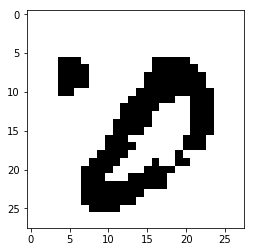

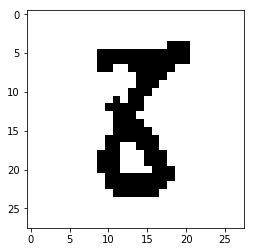

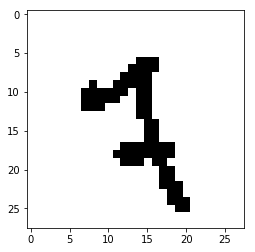

In [18]:
for i in range(3):
    plt.imshow([255 - i for i in x_test_raw[confidence_sorted[i]]], cmap='gray')
    plt.show()
    #"Label: {}".format(y_test_raw[lowest_confidence[i]])